# # データ構造化ハンズオン演習　7
## TEM編 



**対応機種** ：　 J日本電子　JEM-ARM200F  
**rawデータ**：　.dm3 .dm4ファイル　（Gatanフォーマット）
**スクリプトの内容**：  
撮影したrawファイルであるGatanフォーマット（.dm3/.dm4）を登録すると，画像ファイル(.png)および撮影情報をリスト化するデータ構造化のスクリプトを出力します．

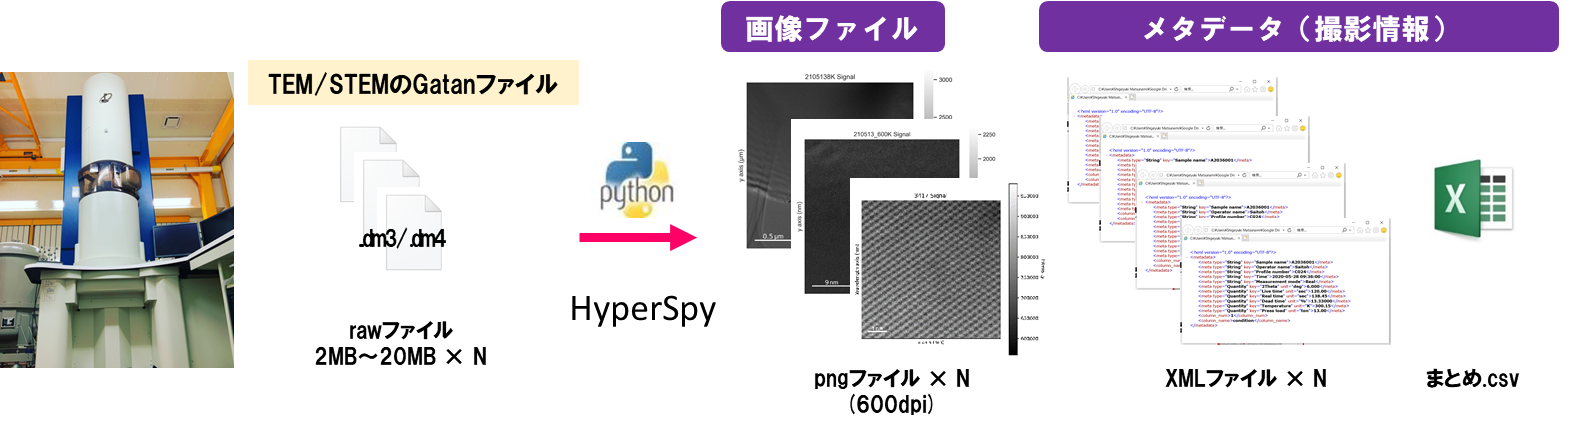

## サンプルデータを読み込みましょう

In [ ]:
!git clone https://github.com/ARIM-Training/Training_Program_7.git
%cd Training_Program_7

これで準備が整いました．

<hr>

## 1. ライブラリーを読み込みましょう
最初にコードを走らせるのに必要なライブラリーを読み込みます．  TEMのデータ処理では，``HyperSpy``という専用ライブラリを使います．

 * 標準ライブラリー: ``glob``, ``os``, ``re``,``shutil``
 * TEM処理用: ``HyperSpy``
 * 数値処理用: ``numpy``
 * 可視化用: ``matplotlib``  
 
 なおGoogle Colabでの動作ではnmrglueをpip installする必要があります．その時は，下記のコメントアウトしている行を実行してください．

In [1]:
# モジュール
import os
import glob
import re
import shutil


# NMR処理用　
#!pip install hyperspy
import nmrglue as ng

# 数値処理用
import numpy as np
import pandas as pd

# 可視化
from matplotlib import pyplot as plt

また，出力結果を「output」フォルダーに保存するため，そのフォルダーの作成をします．

In [2]:
output_folder = 'output'
os.makedirs(output_folder,exist_ok = True)

# 2. HyperSpyの基本動作
``hyperspy``はBrukerやVarianなどの欧米のNMRメーカーのデータはrawデータから読み込めるようになっています．残念ながらJEOLのrawデータ形式である.jdfには対応していません．

代わりにIUPACで標準のテキストフォーマットであるJCAMP-DXは読み込めます．JEOLの出力ファイルとしてJCAMP-DX（.jdx）として，そのファイルを起点として処理する方法を以下では示してゆきます．

なお，実際のデータ蓄積ではrawデータ（.jdf）をJCAMP-DXのコンバーター（converter.exe）を介して.jdxへと変換をかけてpythonへと引き渡す予定としております．

## 2.1.ファイルの読み込み
``nmrglue``のjcampdx.read()モジュールからファイル名を指定します．このモジュールを実行するとメタデータ（``meta_data``）と数値データ(``raw_data``)を返します．

In [3]:
file = 'data/EB_Proton-1.jdx'
meta_data, raw_data  = ng.jcampdx.read(file)

### 2.1.1. メタデータ
``meta_data``は.jdxファイルに出力されている測定パラメータのメタデータで，pythonの辞書形式で格納されます．

In [4]:
meta_data

{'_comments': ['JEOL NMR v1.10',
  '------------------------',
  'JEOL SPECIFIC PARAMETERS',
  'ppm',
  'ppm',
  'ppm',
  'MHz',
  'kHz',
  'Hz',
  'kHz',
  'ppm',
  'dC',
  'us',
  'kHz',
  'ppm',
  'deg',
  'deg',
  'us',
  'us',
  'us',
  's',
  'T',
  'dC',
  'Hz',
  'Hz',
  '%',
  '%',
  'MHz',
  'MHz',
  'ppm',
  's',
  'Hz',
  'ppm',
  's',
  's',
  's',
  's',
  'mdB',
  'deg',
  'dB',
  'dB',
  'mHz',
  'mHz',
  'mHz',
  'mHz',
  's',
  's',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'kHz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  'Hz',
  's',
  'dB',
  's',
  's',
  'us',
  'us',
  'END OF JEOL SPECIFIC PARAMETERS',
  '-------------------------------',
  'checkpoint',
  'checkpoint'],
 'TITLE': ['EB'],
 'JCAMPDX': ['6.00'],
 'DATATYPE': ['NMR SPECTRUM'],
 'DATACLASS': ['NTUPLES'],
 'NUMDIM': ['1'],
 'ORIGIN': ['DELTA2_NMR'],
 'OWNER': ['delta'],
 'LONGDATE': ['2021/05/12 14:28:05'],
 'SPECTROMETERDATASYST

ここから必要なメタデータを抽出することができます．例えばメタデータの'TITLE'を見る場合には以下のようにpythonの辞書形式のルールから得ることができます．

In [5]:
meta_data['TITLE']

['EB']

### 2.1.2. 数値データ
一方で数値部の``raw_data``は実数部と虚数部を``numpy``のarray配列のlist形式で返します．

In [6]:
raw_data

[array([0.000375  , 0.00610869, 0.01023989, ..., 0.00227133, 0.00733475,
        0.00533929]),
 array([ 0.01860309,  0.0218997 ,  0.00991799, ..., -0.01519652,
        -0.01721408, -0.01712195])]

それぞれを可視化してみましょう．  
まずは実数部のデータはlistの最初の配列に格納されている部分です．
``matplotlib``のplotで表示します．

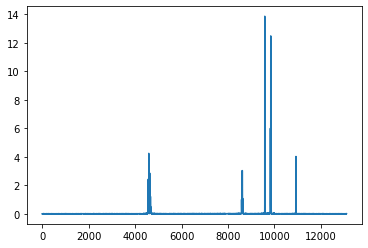

In [7]:
plt.plot(raw_data[0])
plt.show()

続いて虚数部です．listの2番目に格納されている数値郡です．

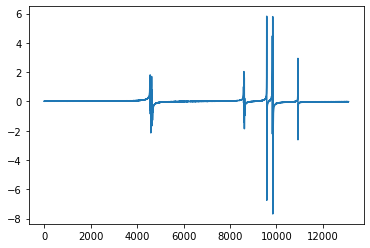

In [8]:
plt.plot(raw_data[1])
plt.show()

実数部および虚数部の横軸はポイント数の数字となっています．  
ポイント数は，次のようにして測定メタデータの中から調べることができます.

In [9]:
meta_data["$XCURRPOINTS"]

['13107']

## 2.2. 軸の変換
スペクトルの作図のための`` axis_convert``関数を次のように作成します．  
jdxがFIDの場合には横軸を時間スケールとするmsecへ，FFTの場合にはケミカルシフトとしてppmへの変換を行います．その変換した数値をx_scaleとして返します．

In [10]:
def axis_convert(file):
    """
    概要: 数値部の抽出
    @param file: jdxファイル
    @return dataframe（数値データ,メタデータ，x軸スケール）
    """

    # ファイルの読み込みとヘッダー部の読み出し
    meta_data, raw_data  = ng.jcampdx.read(file)
    
    npoints = int(meta_data["$XCURRPOINTS"][0])
    data = np.empty((npoints, ), dtype='complex128')
    data.real = raw_data[0][:]
    data.imag = raw_data[1][:]
    
    udic = ng.jcampdx.guess_udic(meta_data, data)
   
    if meta_data['DATATYPE'] == ['NMR SPECTRUM']:
        
        #中心周波数
        udic[0]['car'] = float(meta_data["$XOFFSET"][0])*float(meta_data["$XFREQ"][0])
        
        # PPMスケールの設定
        uc = ng.fileiobase.uc_from_udic(udic)
        x_scale = uc.ppm_scale()
        
    else:
        # msecスケールの設定        
        uc = ng.fileiobase.uc_from_udic(udic)
        x_scale = uc.ms_scale()
    
    return data, meta_data, x_scale

実際にこの関数を走らせてみましょう．FFTのデータであるエチルベンゼンの「EB_Proton-1.jdx」を使います．

In [11]:
file = 'data/EB_Proton-1.jdx'
data, meta_data, x_scale = axis_convert(file)

横軸のx_scaleを見るとppmの値が得られます．

In [12]:
x_scale

array([12.50640157, 12.50525616, 12.50411076, ..., -2.50296532,
       -2.50411072, -2.50525612])

## 2.3. スペクトルの作成
スペクトルの作図は上記の`` axis_convert``関数で得られる数値データ，メタデータ，およびx軸スケールを用います．

In [13]:
def make_spectrum(data, meta_data, x_scale, output_file_name):

    #　図の設定 
    hfont = {'fontname': 'Arial'}
    fig, ax = plt.subplots(1,1, figsize=(16,9))
             
    ax.plot(x_scale,data.real, 'k-')
    
    ax.set_yticklabels([])

    obs_nuc_table = ['^1H','^13C','^15N','^19F','^29Si','^31P']
    nuc_table = ['1H','13C','15N','19F','29Si','31P']
    
    nuc = ''.join(meta_data['.OBSERVENUCLEUS'])
                  
    if nuc in obs_nuc_table:
              
        i = obs_nuc_table.index(nuc)
               
        if meta_data['DATATYPE'] == ['NMR SPECTRUM']:
            ax.invert_xaxis()
            ax.set_title(file + ' ' + nuc_table[i]+'_spectrum', **hfont, fontsize = 16)
            ax.set_xlabel(nuc_table[i]+' ppm',**hfont, fontsize = 14)
        
            #出力
            plt.savefig('output/' + output_file_name + '_'+ nuc_table[i]+'_spectrum.png', dpi=300)
            
        else: 
            ax.set_title(file + ' ' + nuc_table[i]+'_FID', **hfont, fontsize = 16)
            ax.set_xlabel(nuc_table[i]+' msec',**hfont, fontsize = 14)
        
            #出力
            plt.savefig('output/' + output_file_name + '_'+ nuc_table[i]+'_FID.png', dpi=300)

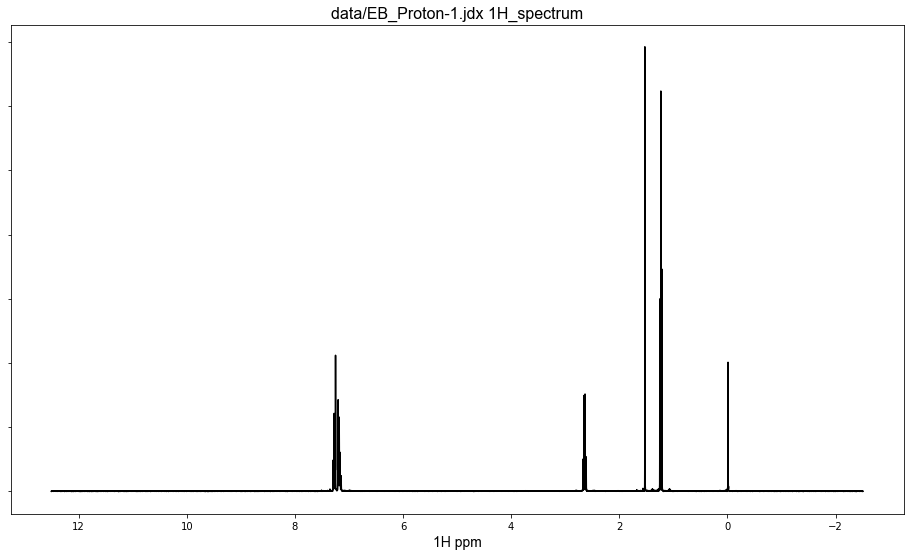

In [14]:
output_file_name = 'EB_Proton-1'
make_spectrum(data, meta_data, x_scale, output_file_name)

## 2.4. Peak Picking
peakリストは強度のしきい値を定めて出力することができます．ここでは最大強度の1/20をしきい値としてピークピッキングを行う処理の流れについて説明をします．  

ピークサーチはnmrglueの``peakpick.pick``モジュールを用います．

In [15]:
#しきい値の設定
threshold = max(data.real)*0.05

#Peak Pincking
peaks = ng.peakpick.pick(data.real, pthres=threshold, algorithm="downward")

### ピッキングしたピークの可視化

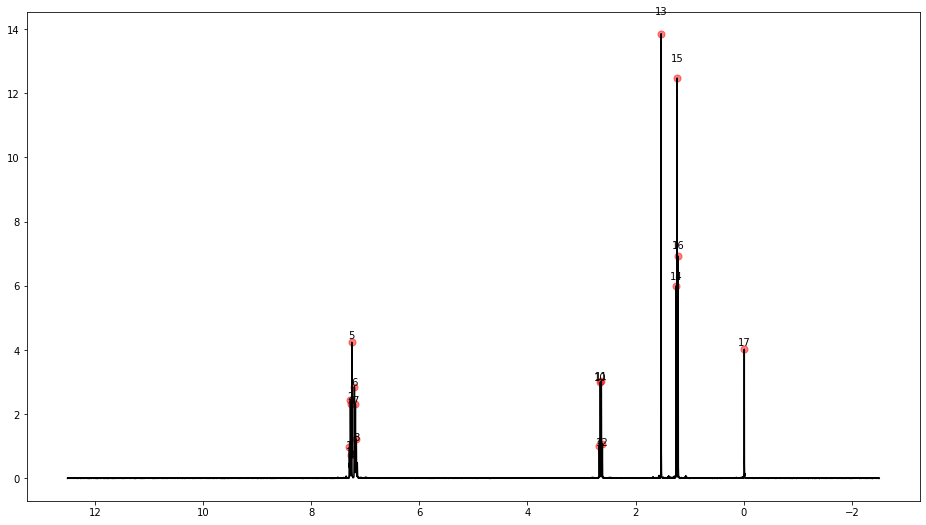

In [16]:
#軸スケールの設定
udic = ng.jcampdx.guess_udic(meta_data, data)
udic[0]['car'] = float(meta_data["$XOFFSET"][0])*float(meta_data["$XFREQ"][0])
uc = ng.fileiobase.uc_from_udic(udic)

height_list = []
ppm_list = []

#　図の設定
hfont = {'fontname': 'Arial'}
fig, ax = plt.subplots(1,1, figsize=(16,9))
             
ax.plot(x_scale,data.real, 'k-')
ax.invert_xaxis()

# マーカーの付与
for n, peak in enumerate(peaks):
    height = data.real[int(peak["X_AXIS"])]
    ppm = uc.ppm(peak["X_AXIS"])
    
    ax.scatter(ppm, height, marker="o", color="r", s=50, alpha=0.5)
    ax.text(ppm, height*1.05, n + 1, ha="center", va="center")
    
    height_list.append(height)
    ppm_list.append(ppm)

### ピークテーブルの作成

In [17]:
peak_list = pd.DataFrame(list(zip(ppm_list,height_list)), columns = ['ppm','height'])
peak_list.index = peak_list.index + 1
peak_list

,ppm,height
1,7.292525,0.974859
2,7.274199,2.428906
3,7.260454,0.716878
4,7.255872,2.319117
5,7.249000,4.239047
6,7.200893,2.854520
7,7.182566,2.313615
8,7.165385,1.215844
9,2.671967,1.003848
10,2.652496,2.987133


# 3. 連続処理化

## 3.1. ファイルの拡張子を調べます
データ構造化の最初のステップとして，データ構造化するファイルを特定する必要があります．その特定は**拡張子**で判定します．  
下記の``read_files``関数は入力ファイルが置いてある「data」フォルダーにある特定の拡張子のファイルをすべてリスト化します．ここでは単一のファイルではなく複数のファイルが扱えることを想定しています．

もしエラーがでたら「data」フォルダーを作成し，その中に.jdxファイルを配置してみてください．

In [18]:
def read_files(extension):
    """
    概要: 特定の拡張子のついたファイルをすべて読み込む
    @param extension: 読み込む拡張子
    @return 拡張子をぬいたファイル名，　ファイル数，　出力で使うファイル名
    """

    if extension == 'jdx':
        path = 'data/*.' + extension
    
    else:
        path = 'output/*.' + extension
        
    # 読み込みファイルの取得

    input_files = glob.glob(path)
    print (input_files)

    # 読み込みファイル数の取得
    number_of_files = len(input_files)

    # 拡張子を抜いたファイル名（出力用）
    output_name = [os.path.splitext(os.path.basename(p))[0] for p in input_files]

    return input_files, number_of_files, output_name


JEOLのNMRのJCAMPファイル（テキスト）である``.jdx``を含むファイルを指定してみましょう．

In [19]:
default_extension = 'jdx'
read_files(default_extension)

['data\\EB_Proton-1.jdx']


(['data\\EB_Proton-1.jdx'], 1, ['EB_Proton-1'])

上記のようにリスト配列の結果が戻ります．  
１つ目は「data」フォルダーにある.jdxのファイル名（相対パス形式），２つ目はファイル数，３つ目は拡張子（.jdx）を省いたファイル名です．  
３番目はグラフのタイトルや出力ファイル名で使うために準備します．

## 3.2. サムネイル画像の作成（読み飛ばしOK）
複数のファイルが登録された場合にどこ画像を代表サムネイルとするかを判定します．  
ここではFFTとFIDであれば，FFTを優先します．また複数の観測核があった場合には最も元素番号が大きいものを選ぶ判定をします．

In [20]:
def make_thumbnail(input_files):
    
    # 分類
    spectrum_files = [s for s in input_files if 'spectrum' in s]
    fid_files = [s for s in input_files if 'FID' in s]
    
    #観測核の元素番号
    nuc_numbers = []
    
    #辞書化
    spec = {}

    #検出パターン
    pattern_spec = re.compile(r'_\d+\w+_spectrum')
    pattern_FID = re.compile(r'_\d+\w+_FID')
    pattern_num = re.compile(r'\d+') 

    #スペクトルファイルの辞書
    if spectrum_files:
        for name in spectrum_files:
            num = pattern_spec.findall(name)
            num2 = pattern_num.findall(num[0])
            nuc_numbers.append(int(num2[0]))
        
            spec = dict(zip(nuc_numbers,spectrum_files))
    
    #スペクトルファイルがなければFIDの辞書
    else:
        for name in fid_files:
            num = pattern_FID.findall(name)
            num2 = pattern_num.findall(num[0])
            nuc_numbers.append(int(num2[0])) 
            
            spec = dict(zip(nuc_numbers,fid_files))

    #最大値のファイルを選択
    max_k, max_v = max(spec.items(), key=lambda x: x[0])
    
    #サムネイル画像の作成
    shutil.copyfile(max_v,'output/main.png')

## 3.3.  一本化する
上記の一連の処理を一本化することをします．下記のように一本化したコードを``main``関数として定義しておきます．処理の順番を並べるだけです．
また，上記ではファイルが一つだけを想定していました．下記の``main``では複数の.rasファイルがある場合にでも実行できるよう``for``ループにしています．

計測では複数ファイルを一括して処理する場合がほとんどですので，このような一連の処理は``for``ループ化しておくと作業効率化に効いてきます．

In [21]:
def main():
        
    # jcampデータの取り込み
    default_extension = 'jdx'

    # ファイルの読み込み
    [files, f_num, fname] = read_files(default_extension)
    
    print('\n read jdx files\n')    
    print(files)
    
    # データ抽出（1次元スペクトルのみ可視化）
    for i in range(f_num):
        
        #　データ抽出
        data, meta_data, x_scale = axis_convert(files[i])

        if meta_data['NUMDIM']==['1']:    
            make_spectrum(data, meta_data, x_scale, fname[i]) 
            
        else:
            continue
    
    # 画像データの取り込み
    default_extension = 'png'
    
    # 画像ファイルの読み込み
    [files, f_num, fname] = read_files(default_extension)
    
    print('\n read png files\n')
    print(files)
    
    #サムネイル画像（代表図）の作成
    make_thumbnail(files)

その``main``関数を下記のようにして走らせてみましょう．一連の処理が一貫で行われます．

['data\\EB_Proton-1.jdx']

 read jdx files

['data\\EB_Proton-1.jdx']
['output\\EB_Proton-1_1H_spectrum.png']

 read png files

['output\\EB_Proton-1_1H_spectrum.png']


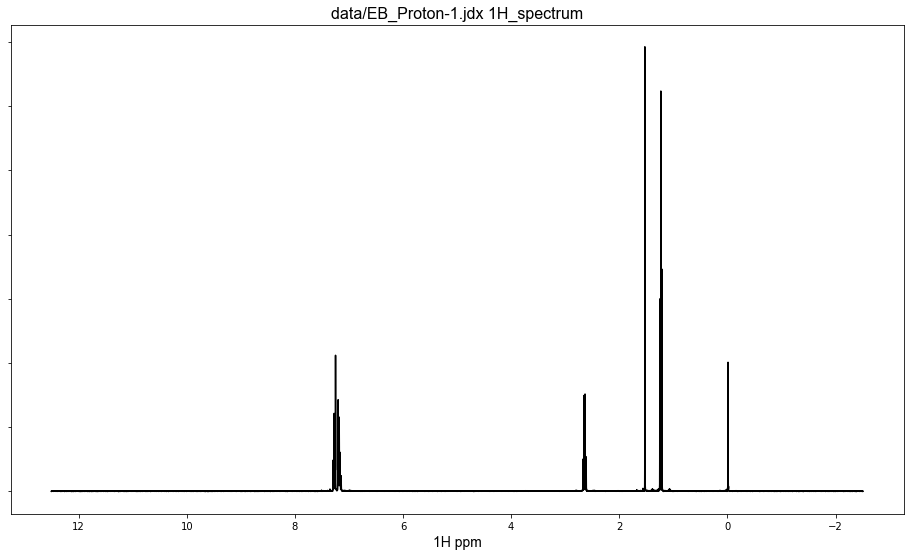

In [22]:
main()

では出力されたグラフおよびCSVを取り出して見てみましょう. PCをお使いの方々はoutput_folderというフォルダーを見れば, グラフとCSVが出力されています.
Google Colaboratoryをお使いの方々は, まず下のコマンドコードを実行してください.

In [ ]:
!pwd
!ls

現在プログラムを実行しているフォルダーがTraining_Program_1というところで, そこにdataフォルダーやoutputフォルダー, READMEやこのプログラムの書かれたノートブックのファイルであるTraining_1.ipynbもあります. では、次のコマンドコードでoutputフォルダーに移動してみましょう.

In [ ]:
%cd output/
!ls

XRD_RIGAKU_extract.csvというCSVファイルと, XRD_RIGAKU.pngという画像ファイルが出てきました. これを以下のプログラムコードを実行して取り出して見ましょう.

In [ ]:
from google.colab import files

files.download("XRD_RIGAKU_extract.csv")

CSVファイルが無事にダウンロード出来ましたでしょうか. グラフの描かれた画像ファイルも同様にダウンロードできます.

In [ ]:
files.download("XRD_RIGAKU.png")

## おわりに
上記はNMRの一次元スペクトルの最も基本形のシンプルなタイプのデータ構造化の事例となります．

* JCAMP-DX型（テキスト）を読み込む
* FIDかFFTかによって横軸のスケールを変換する
* 数値部から可視化図を作成して保存する

あとは，お好みに応じて``make_figure``関数の設定を触りながらオリジナルのデザインを進めてゆくことで調整します．